In [1]:
%matplotlib inline              
from pylab import *

In [2]:
# Calculation of the stationary distribution of an M/M/C/C
def p(rho,C):
    pi_   = ones(C+1)
    for k in range(C):
        #####################
        # supply the expression of pi_[k+1]
        # in terms of pi_[k]
        pi_[k+1] = rho**(k + 1) * pi_[0] / math.factorial(k + 1)
        #####################
    pi_ = pi_/sum(pi_)
    return pi_

#----------
V1 = p(1,4)[0]

In [3]:
#############
# Complete the code of Erlang B formula 
def Eb(rho,C):
    numerator = rho**C / math.factorial(C)
    denominator = sum([rho**i / math.factorial(i) for i in range(C+1)])
    return numerator / denominator
#############
lambda_, mu, C = 1., 1., 4
V2 = Eb(lambda_/mu,C)

In [4]:
from ipywidgets import *
rcParams['figure.figsize'] = 10,7
def plt_Eb(C):
    # plot of rho -->Eb(rho,c)
    C_max   = 20
    rho_max = 4
    ymin    = 1.0e-7
    ymax    = 60
    rho     = linspace(0,rho_max,100)

    plot(rho, [100*Eb(r,C) for r in rho])
    grid('on')
    xlabel(r"Offered Load $\rho$", fontsize=20)
    ylabel(r"$E_B (\%)$", fontsize=20)
    title("Loss probability", fontsize=20)
    def point_loss(x,y,color,label):
        # point rho=x and loss_probability=y%
        semilogy(x,y,'o',color=color,label=label)
        semilogy((0,rho_max),(y,y),'r',linewidth=.4)
    semilogy((1,1),(ymin,ymax),'r',linewidth=.4)     
    # point of loss probability 1%
    point_loss(1,3,color='b',label=r'$E_B=3\%$')
    point_loss(1,.5,color='g',label=r'$E_B=0.5\%$')
    legend(fontsize=20)
    axis(xmin=0,xmax=rho_max,ymin=ymin,ymax=ymax)
    show()

# interactive plot of rho -->Eb(rho,c) for varying c
interact(plt_Eb, C=(1,10,1))

#######################
# supply the minimum values of C such that Eb<3% and Eb<.5%
V3 = 4   # min value of C such that Eb(1,C)<3%
V4 = 5   # min value of C such that Eb(1,C)<.5%
#######################

interactive(children=(IntSlider(value=5, description='C', max=10, min=1), Output()), _dom_classes=('widget-int…

In [5]:
def ab_to_i(a,b):
    # index conversion (a,b)-->i
    # (a,b) stands for the state (N,N') 
    # and i for the corresponding line or column index of Q
    # note that matrix and state pairs indexing begin at 0
    return int(a*(C+1)-a*(a-1)/2 + b)

def matQ(lambda_s,mu,lambda_o,C):
    # building Q
    s = int((C+1)**2-C*(C+1)/2)
    Q = zeros(shape=(s,s))
    for a in range(C+1):       # loop over N
        for b in range(C+1-a): # loop over N'
            i = ab_to_i(a,b)   # corresponding index in the matrix Q
            if b>0: # transition (a,b)-->(a,b-1)
                Q[i,ab_to_i(a,b-1)]     = b*mu 
            if a>0: # transition (a,b)-->(a-1,b)
                Q[i,ab_to_i(a-1,b)]     = a*mu 
            if b<C-a: # transition (a,b)-->(a,b+1)
                Q[i,ab_to_i(a,b+1)]     = lambda_o 
                if i<s-1: # transition (a,b)-->(a+1,b)
                    Q[i,ab_to_i(a+1,b)] = lambda_s 
            elif i<s-1: # transition (a,C-a)-->(a+1,C-a-1)
                Q[i,ab_to_i(a+1,b-1)]   = lambda_s      
            ############################
            # Supply the value of Q[i,i]
            Q[i,i] = 0 - sum(Q[i,:])  # setting constraint sum(Q[i,:])=0
            ############################
    return Q

lambda_s,mu,lambda_o,C = 1,1,2,3
matQ(lambda_s,mu,lambda_o,C)

array([[-3.,  2.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 1., -4.,  2.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  2., -5.,  2.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  3., -4.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0., -4.,  2.,  0.,  1.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  1., -5.,  2.,  0.,  1.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  2., -4.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  2.,  0.,  0., -5.,  2.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  2.,  0.,  1., -4.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  3.,  0., -3.]])

In [6]:
from scipy.linalg import lstsq

In [7]:
set_printoptions(precision=4)
lambda_s,mu,lambda_o,C = 1,1,2,4
A     = matQ(lambda_s,mu,lambda_o,C).T
m,n   = A.shape
A     = vstack((A,ones(n))) # adding constraint sum(pi[i])=1
b     = zeros(m+1)
b[-1] = 1
# solves equations pi.Q=0 and normalization condition
pi_Q  = lstsq(A,b)[0] 
##########################
# supply the blocking probability for for suscribers 
# and occasional users
def blocking(pi_Q,C):
    #returns blocking probability for suscribers (P_s)
    # and occasional users (P_o)
    # blocking probability = P(all servers busy) = Pi_c
    # 0 1 2 3 4
    # 5 6 7 8
    # 9 10 11
    # 12 13
    # 14
    # sum all states where all servers are busy with only subscribing users aka state 14
    P_s = pi_Q[-1] 
    # sum all states where all servers are busy (N + N' = C)
    temp = C
    tot = C
    P_o = 0
    while temp >= 0:
        P_o += pi_Q[tot]
        tot = tot + temp
        temp = temp - 1
    return P_s, P_o
##########################
V5,V6 = blocking(pi_Q,C)
print("The blocking probability for N  is %.3f" %V5)
print('Erlang B formula yields Eb(',lambda_s/mu,',',C,
                          ') = %.3f' %Eb(lambda_s/mu,C))
print("The blocking probability for N' is %.3f" %V6)

The blocking probability for N  is 0.015
Erlang B formula yields Eb( 1.0 , 4 ) = 0.015
The blocking probability for N' is 0.206


Text(0, 0.5, 'Blocking probability')

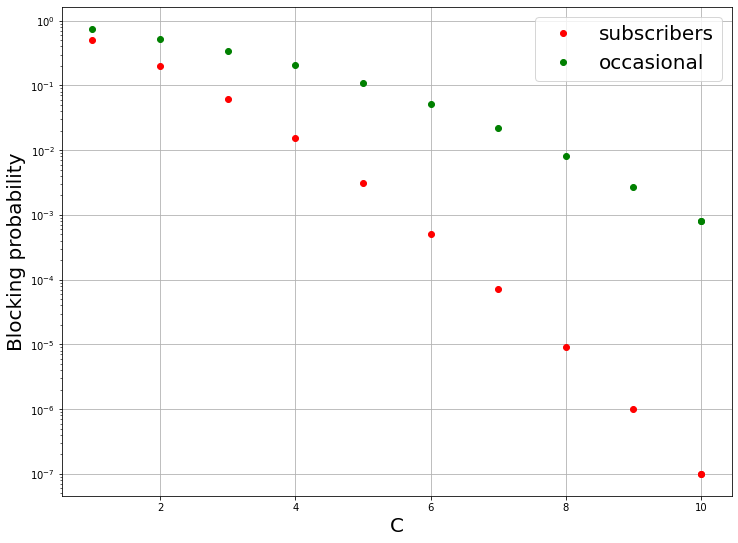

In [8]:
Cmax = 10
rcParams["figure.figsize"] = 12,9
for C in range(1,Cmax+1):
    A     = matQ(lambda_s,mu,lambda_o,C).T
    m,n   = A.shape
    A     = vstack((A,ones(n))) # adding constraint sum(pi[i])=1
    b     = zeros(m+1)
    b[-1] = 1
    # solves equations pi.Q=0 and normalization condition
    pi_Q  = lstsq(A,b)[0] 
    P_s,P_o = blocking(pi_Q,C)
    semilogy(C,P_s,'or')
    semilogy(C,P_o,'og')
semilogy(C,P_s,'or',label='subscribers')
semilogy(C,P_o,'og',label='occasional')
grid('on')
legend(fontsize=20)
xlabel('C',fontsize=20)
ylabel('Blocking probability',fontsize=20)

In [9]:
print("---------------------------\n"
      +"RESULTS SUPPLIED FOR LAB 5:\n"
      +"---------------------------")
results = ("V"+str(k) for k in range(1,7))
for x in results:
    try:
        print(x+" = {0:.3f}".format(eval(x)))
    except:
        print(x+": variable is undefined")   

---------------------------
RESULTS SUPPLIED FOR LAB 5:
---------------------------
V1 = 0.369
V2 = 0.015
V3 = 4.000
V4 = 5.000
V5 = 0.015
V6 = 0.206
